In [1]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
#assert pyro.__version__.startswith('1.3.0')
pyro.enable_validation(True)
pyro.set_rng_seed(20200305)

## Intro to state space models

In [4]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


torch.Size([78888, 1])


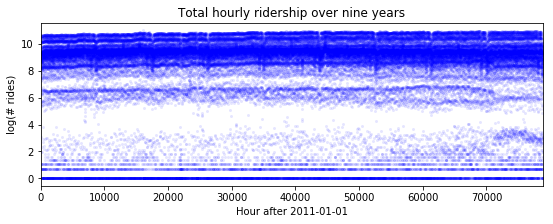

In [12]:
data = dataset["counts"].sum([-1, -2]).unsqueeze(-1).log1p()
print(data.shape)
plt.figure(figsize=(9, 3))
plt.plot(data, 'b.', alpha=0.1, markeredgewidth=0)
plt.title("Total hourly ridership over nine years")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(0, len(data));

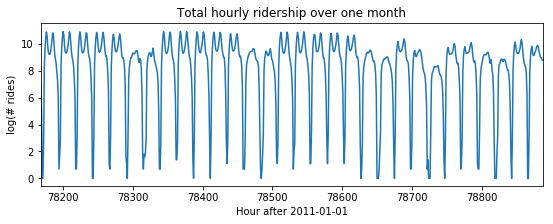

In [16]:
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total hourly ridership over one month")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(len(data) - 24 * 30, len(data));

## GaussianHMM

In [17]:
T0 = 0                # beginning
T2 = data.size(-2)    # end
T1 = T2 - 24 * 7 * 2  # train/test split
means = data[:T1 // (24 * 7) * 24 * 7].reshape(-1, 24 * 7).mean(0) # Mean semanal

In [53]:
data.shape, data.dtype

(torch.Size([78888, 1]), torch.float32)

In [20]:
T0, T1, T2, means.shape

(0, 78552, 78888, torch.Size([168]))

In [22]:
data[:T1 // (24 * 7) * 24 * 7].shape

torch.Size([78456, 1])

In [24]:
T1 // (24 * 7) * 24 * 7

78456

In [25]:
data[:T1 // (24 * 7) * 24 * 7].reshape(-1, 24 * 7).shape

torch.Size([467, 168])

In [27]:
T1 // (24 * 7) * 24 * 7

78456

In [28]:
class Model1(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)

        # We'll hard-code the periodic part of this model, learning only the local model.
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)

        # On top of this mean prediction, we'll learn a linear dynamical system.
        # This requires specifying five pieces of data, on which we will put structured priors.
        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)

        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        # Note timescale is a scalar but we need a 1x1 transition matrix (hidden_dim=1),
        # thus we unsqueeze twice using [..., None, None].
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)

        # Note the obs_matrix has shape hidden_dim x obs_dim = 1 x 1.
        obs_matrix = torch.tensor([[1.]])
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)

        noise_dist = dist.GaussianHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

In [31]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1, num_steps=400)

INFO 	 step    0 loss = 0.878717
INFO 	 step  100 loss = 0.650697
INFO 	 step  200 loss = 0.650598
INFO 	 step  300 loss = 0.650569


CPU times: user 1min 43s, sys: 192 ms, total: 1min 43s
Wall time: 15.4 s


In [33]:
T1

78552

In [35]:
covariates[:T1]

tensor([], size=(78552, 0))

In [32]:
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

timescale = 4.453
trans_scale = 0.4567
obs_scale = 0.05883


torch.Size([100, 336, 1]) torch.Size([336])


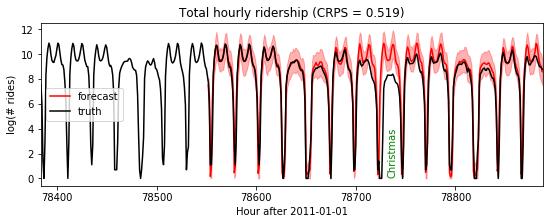

In [30]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 7, T2)
plt.text(78732, 3.5, "Christmas", rotation=90, color="green")
plt.legend(loc="best");

In [36]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)

        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)
        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)
        obs_matrix = torch.tensor([[1.]])

        # To model heteroskedastic observation noise, we'll sample obs_scale inside a plate,
        # then repeat to full duration. This is the only change from Model1.
        with pyro.plate("hour_of_week", 24 * 7, dim=-1):
            obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_scale = periodic_repeat(obs_scale, duration, dim=-1)

        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)
        noise_dist = dist.GaussianHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

In [37]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model2(), data[:T1], covariates[:T1], learning_rate=0.1, num_steps=400)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 0.954784
INFO 	 step  100 loss = -0.0342973
INFO 	 step  200 loss = -0.0372895
INFO 	 step  300 loss = -0.0375589


timescale = 61.39
trans_scale = 0.109
CPU times: user 1min 56s, sys: 204 ms, total: 1min 56s
Wall time: 18.4 s


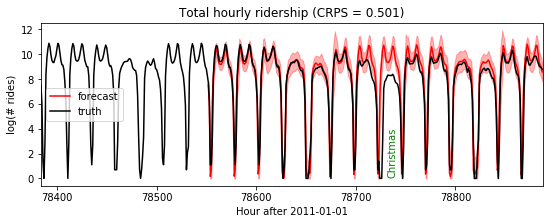

In [38]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 7, T2)
plt.text(78732, 3.5, "Christmas", rotation=90, color="green")
plt.legend(loc="best");

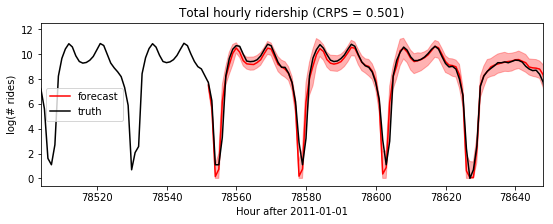

In [39]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 2, T1 + 24 * 4)
plt.legend(loc="best");

## Heavy-tailed modeling with LinearHMM

In [40]:
class Model3(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)

        # First sample the Gaussian-like parameters as in previous models.
        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)
        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        obs_matrix = torch.tensor([[1.]])
        with pyro.plate("hour_of_week", 24 * 7, dim=-1):
            obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_scale = periodic_repeat(obs_scale, duration, dim=-1)

        # In addition to the Gaussian parameters, we will learn a global stability
        # parameter to determine tail weights, and an observation skew parameter.
        stability = pyro.sample("stability", dist.Uniform(1, 2).expand([1]).to_event(1))
        skew = pyro.sample("skew", dist.Uniform(-1, 1).expand([1]).to_event(1))

        # Next we construct stable distributions and a linear-stable HMM distribution.
        trans_dist = dist.Stable(stability, 0, trans_scale.unsqueeze(-1)).to_event(1)
        obs_dist = dist.Stable(stability, skew, obs_scale.unsqueeze(-1)).to_event(1)
        noise_dist = dist.LinearHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)

        # Finally we use a reparameterizer to enable inference.
        rep = LinearHMMReparam(None,                     # init_dist is already Gaussian.
                               SymmetricStableReparam(), # trans_dist is symmetric.
                               StableReparam())          # obs_dist is asymmetric.
        with poutine.reparam(config={"residual": rep}):
            self.predict(noise_dist, prediction)

In [41]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model3(), data[:T1], covariates[:T1], learning_rate=0.1)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 42.9186
INFO 	 step  100 loss = 0.243554
INFO 	 step  200 loss = 0.112086
INFO 	 step  300 loss = 0.0318487
INFO 	 step  400 loss = -0.0420917
INFO 	 step  500 loss = -0.0765423
INFO 	 step  600 loss = -0.108931
INFO 	 step  700 loss = -0.129285
INFO 	 step  800 loss = -0.143141
INFO 	 step  900 loss = -0.173773
INFO 	 step 1000 loss = -0.172425


timescale = 11.22
trans_scale = 0.04193
stability = 1.68
skew = -0.0001891
CPU times: user 19min 27s, sys: 7.31 s, total: 19min 34s
Wall time: 3min 22s


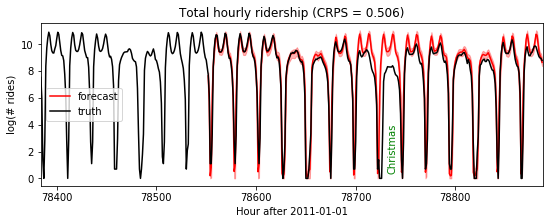

In [42]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 7, T2)
plt.text(78732, 3.5, "Christmas", rotation=90, color="green")
plt.legend(loc="best");

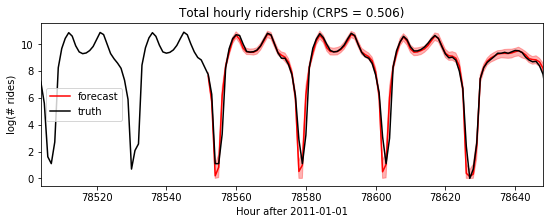

In [43]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 2, T1 + 24 * 4)
plt.legend(loc="best");